In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai import *
from fastai.tabular import *
import os
import time
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import random
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score

from matplotlib import pyplot as plt

from fastai import *
from fastai.tabular import *
from fastai.basic_data import DataBunch
from tqdm import tqdm_notebook

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os

In [3]:
os.getcwd()

'/storage/santander_comp/nbs'

In [3]:
PATH = Path('/storage/santander_comp/')

In [5]:
train = pd.read_csv(PATH/'train.csv', engine = 'python')

In [4]:
test = pd.read_csv(PATH/'test.csv', engine = 'python')

In [5]:
test_IDs = test.ID_code
test.drop('ID_code', inplace = True, axis = 1)

In [6]:
test_IDs.to_csv('testIDs.csv', index = False)

In [41]:
# get the features list
features = [feature for feature in train.columns if 'var' in feature]
len(features)

801

In [10]:
def augment_df(df):
    for feature in features:
        df[f'sq_{feature}'] = df[feature]**2
        df[f'repo_{feature}'] = df[feature].apply(lambda x: 0 if x==0 else 1/x)
        df[f'repo_sq_{feature}'] = df[f'sq_{feature}'].apply(lambda x: 0 if x==0 else 1/x)
    
    df['min'] = df[features].min(axis=1)
    df['mean'] = df[features].mean(axis=1)
    df['max'] = df[features].max(axis=1)
    df['median'] = df[features].median(axis=1)
    df['std'] = df[features].std(axis=1)
    df['var'] = df[features].var(axis=1)
    df['abs_mean'] = df[features].abs().mean(axis=1)
    df['abs_median'] = df[features].abs().median(axis=1)
    df['abs_std'] = df[features].abs().std(axis=1)
    df['skew'] = df[features].skew(axis=1)
    df['kurt'] = df[features].kurt(axis=1)
    
    df['sq_kurt'] = df[[f'sq_{feature}' for feature in features]].kurt(axis=1)
    

In [11]:
augment_df(train)
train.head()

,target,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,var_8,...,max,median,std,var,abs_mean,abs_median,abs_std,skew,kurt,sq_kurt
0,0,8.9255,-6.7863,11.9081,5.0930,11.4607,-9.2834,5.1187,18.6266,-4.9200,...,43.1127,6.77040,9.331540,87.077642,9.433039,8.41525,7.136966,0.101580,1.331023,23.320706
1,0,11.5006,-4.1473,13.8588,5.3890,12.3622,7.0433,5.6208,16.5338,3.1468,...,40.5632,7.22315,10.336130,106.835574,9.684721,8.03470,7.931169,-0.351734,4.110215,21.143081
2,0,8.6093,-2.7457,12.0805,7.8928,10.5825,-9.0837,6.9427,14.6155,-4.9193,...,33.8820,5.89940,8.753387,76.621777,8.618451,7.28465,6.376510,-0.056957,0.546438,10.849758
3,0,11.0604,-2.1518,8.9522,7.1957,12.5846,-1.8361,5.8428,14.9250,-5.8609,...,38.1015,6.70260,9.594064,92.046058,9.095397,7.74480,7.113447,-0.480116,2.630499,14.138277
4,0,9.8369,-1.4834,12.8746,6.6375,12.2772,2.4486,5.9405,19.2514,6.2654,...,41.1037,6.94735,11.287122,127.399113,9.884620,7.89575,8.676483,-1.463426,9.787399,64.143395


In [12]:
augment_df(test)
test.head()

,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,var_8,var_9,...,max,median,std,var,abs_mean,abs_median,abs_std,skew,kurt,sq_kurt
0,11.0656,7.7798,12.9536,9.4292,11.4327,-2.3805,5.8493,18.2675,2.1337,8.8100,...,42.0248,7.31440,9.910632,98.220627,9.576049,8.47350,7.515516,-0.088518,1.871262,15.607325
1,8.5304,1.2543,11.3047,5.1858,9.1974,-4.0117,6.0196,18.6316,-4.4131,5.9739,...,35.6020,6.43960,9.541267,91.035772,8.960003,7.94920,7.042000,-0.559785,3.391068,20.159428
2,5.4827,-10.3581,10.1407,7.0479,10.2628,9.8052,4.8950,20.2537,1.5233,8.3442,...,39.3654,7.26355,9.967466,99.350374,9.554517,8.27835,7.681205,-0.135084,2.326901,12.575372
3,8.5374,-1.3222,12.0220,6.5749,8.8458,3.1744,4.9397,20.5660,3.3755,7.4578,...,40.3383,6.89675,8.257204,68.181422,8.826497,7.91085,6.319616,-0.167741,2.253054,30.958931
4,11.7058,-0.1327,14.1295,7.7506,9.1035,-8.5848,6.8595,10.6048,2.9890,7.1437,...,45.5510,6.83375,10.043542,100.872731,9.634084,8.60380,7.649904,0.293484,2.044943,24.871054


In [13]:
train.to_csv('train_aug.csv', index=False)

In [14]:
test.to_csv('test_aug.csv', index = False)

In [15]:
random.seed(201)
valid_idx = random.sample(list(train.index.values), int(len(train)*0.1) )

In [16]:
valid_idx

[17590,
 187263,
 85353,
 110190,
 963,
 74133,
 85507,
 197314,
 183367,
 181895,
 178832,
 123174,
 162717,
 197575,
 70963,
 118232,
 126404,
 146583,
 159913,
 124291,
 36603,
 148562,
 124984,
 16323,
 140448,
 60195,
 56380,
 182267,
 49503,
 3607,
 78514,
 28175,
 62814,
 146409,
 69958,
 47382,
 171529,
 197432,
 126407,
 174469,
 187811,
 7975,
 150861,
 20475,
 199348,
 168696,
 188586,
 106790,
 131221,
 141183,
 199657,
 146257,
 178987,
 194977,
 76926,
 127194,
 24773,
 199722,
 153006,
 81830,
 140138,
 91046,
 147136,
 98763,
 49162,
 7850,
 107777,
 115539,
 186238,
 10672,
 109771,
 70827,
 3516,
 52943,
 108448,
 186826,
 65194,
 132603,
 3260,
 65995,
 174429,
 155090,
 164759,
 83572,
 28086,
 182597,
 70396,
 89743,
 50303,
 79144,
 154037,
 9068,
 47157,
 128434,
 113770,
 155423,
 76751,
 149566,
 137443,
 1564,
 19119,
 97687,
 133496,
 134132,
 46866,
 20416,
 53249,
 9794,
 140342,
 190863,
 95065,
 128205,
 118691,
 644,
 8604,
 57373,
 194056,
 129343,
 120

In [ ]:
train.iloc[valid_idx].target.sum() / len(valid_idx) , train.target.sum() / len(train)



In [39]:
features = features + [f'sq_{feature}' for feature in features] + [f'repo_{feature}' for feature in features] + [f'repo_sq_{feature}' for feature in features]


12813

In [42]:
features += [feature for feature in train.columns[800:]]
len(features) 

814

In [43]:
features

['var_0',
 'var_1',
 'var_2',
 'var_3',
 'var_4',
 'var_5',
 'var_6',
 'var_7',
 'var_8',
 'var_9',
 'var_10',
 'var_11',
 'var_12',
 'var_13',
 'var_14',
 'var_15',
 'var_16',
 'var_17',
 'var_18',
 'var_19',
 'var_20',
 'var_21',
 'var_22',
 'var_23',
 'var_24',
 'var_25',
 'var_26',
 'var_27',
 'var_28',
 'var_29',
 'var_30',
 'var_31',
 'var_32',
 'var_33',
 'var_34',
 'var_35',
 'var_36',
 'var_37',
 'var_38',
 'var_39',
 'var_40',
 'var_41',
 'var_42',
 'var_43',
 'var_44',
 'var_45',
 'var_46',
 'var_47',
 'var_48',
 'var_49',
 'var_50',
 'var_51',
 'var_52',
 'var_53',
 'var_54',
 'var_55',
 'var_56',
 'var_57',
 'var_58',
 'var_59',
 'var_60',
 'var_61',
 'var_62',
 'var_63',
 'var_64',
 'var_65',
 'var_66',
 'var_67',
 'var_68',
 'var_69',
 'var_70',
 'var_71',
 'var_72',
 'var_73',
 'var_74',
 'var_75',
 'var_76',
 'var_77',
 'var_78',
 'var_79',
 'var_80',
 'var_81',
 'var_82',
 'var_83',
 'var_84',
 'var_85',
 'var_86',
 'var_87',
 'var_88',
 'var_89',
 'var_90',
 'var_91'

In [44]:
class roc(Callback):
    '''
    ROC_AUC metric callback for fastai. Compute ROC score over each batch and returns the average over batches.
    TO DO: rolling average
    '''
    def on_epoch_begin(self, **kwargs):
        self.total = 0
        self.batch_count = 0
    
    def on_batch_end(self, last_output, last_target, **kwargs):
        preds = F.softmax(last_output, dim=1)
        # roc_auc_score does not work on batches which does not contain both classes.
        try:
            roc_score = roc_auc_score(to_np(last_target), to_np(preds[:,1]))
            self.total += roc_score
            self.batch_count += 1
        except:
            pass
    
    def on_epoch_end(self, num_batch, **kwargs):
        self.metric = self.total/self.batch_count

In [45]:
data = TabularDataBunch.from_df(path='.', df=train, 
                                    dep_var='target', 
                                    valid_idx=valid_idx, 
                                    cat_names=[], 
                                    cont_names=features, 
                                    bs=512,
                                    procs=[],
                                    test_df=test)

In [46]:
learner = tabular_learner(data, layers = [500, 200, 100], ps = [0.5, 0.2, 0.1], metrics = [roc()])

In [47]:
learner.fit_one_cycle(2)

epoch,train_loss,valid_loss,roc
1,0.232457,0.393693,0.872173
2,0.217862,2.093959,0.880257


In [48]:
learner.lr_find(start_lr=1e-15)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


Min numerical gradient: 3.98E-14


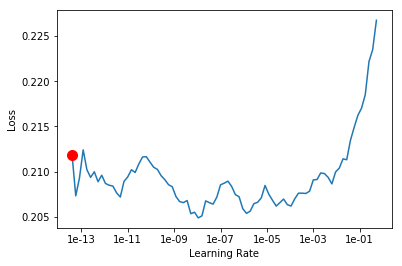

In [49]:
learner.recorder.plot()

In [51]:
learner.fit_one_cycle(6)

epoch,train_loss,valid_loss,roc
1,0.216923,0.533095,0.875028
2,0.215198,3.924679,0.872494
3,0.212725,3.969534,0.875376
4,0.204338,4.380706,0.870358
5,0.183125,6.845026,0.866143
6,0.167531,10.697691,0.862720


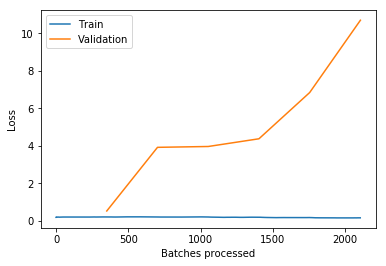

In [52]:
learner.recorder.plot_losses()

In [ ]:
def train_and_eval(train_df, features, valid_idx, lr, epochs, name='learner'):
    learner.fit_one_cycle(epochs, lr)
    
    # run prediction on validation set
    valid_predicts, _ = learner.get_preds(ds_type=DatasetType.Valid)
    valid_probs = np.array(valid_predicts[:,1])
    valid_targets = train_df.loc[valid_idx].target.values
    valid_score = roc_auc_score(valid_targets, valid_probs)
    
    # run prediction on test    
    test_predicts, _ = learner.get_preds(ds_type=DatasetType.Test)
    test_probs = to_np(test_predicts[:, 1])

    learner.save(name,with_opt=False)
    return valid_score, valid_probs, test_probs

In [ ]:
def train_and_eval_tabular_learner(train_df,
                                   train_features, 
                                   valid_idx,
                                   lr=0.02, epochs=1, layers=[200, 100], ps=[0.2, 0.1], name='learner'):
    data = TabularDataBunch.from_df(path='.', df=train_df, 
                                    dep_var='target', 
                                    valid_idx=valid_idx, 
                                    cat_names=[], 
                                    cont_names=train_features, 
                                    bs=BATCH_SIZE,
                                    procs=[],
                                    test_df=test)
    learner = tabular_learner(data, layers=layers, ps=ps, metrics=[accuracy, roc()])
    learner.fit_one_cycle(epochs, lr)
    
    # run prediction on validation set
    valid_predicts, _ = learner.get_preds(ds_type=DatasetType.Valid)
    valid_probs = np.array(valid_predicts[:,1])
    valid_targets = train_df.loc[valid_idx].target.values
    valid_score = roc_auc_score(valid_targets, valid_probs)
    
    # run prediction on test    
    test_predicts, _ = learner.get_preds(ds_type=DatasetType.Test)
    test_probs = to_np(test_predicts[:, 1])

    learner.save(name,with_opt=False)
    return valid_score, valid_probs, test_probs

In [ ]:
BATCH_SIZE = 512

In [ ]:
sub_features = []
valid_scores = []
valid_predictions = []
predictions = []
num_epochs = 200

cv_counts = len(train)//num_epochs

for i in range(num_epochs):
    print('training model {:}'.format(i))
    sub_features.append(random.sample(list(features),600) + augmented_features)
    name = f'learner_{i}'
    score, valid_probs, test_probs = train_and_eval(train, sub_features[-1], valid_idx, epochs=4, lr=0.02)
    valid_scores.append(score)
    valid_predictions.append(valid_probs)
    predictions.append(test_probs)

In [ ]:
procs = [FillMissing, Normalize]
dep_var = 'target'
# cat_names = ['phase']
# valid_idx = range(len(train_signal)-2000, len(train_signal))
# valid_idx = range(len(df_sub)-2, len(df_sub))

In [ ]:
data = TabularDataBunch.from_df(path='.', df=train, 
                                    dep_var='target', 
                                    valid_idx=valid_idx, 
                                    cat_names=[], 
                                    cont_names=features, 
                                    bs=512,
                                    procs=[],
                                    test_df=test)

In [ ]:
data = TabularDataBunch.from_df(PATH, 
                                train, 
                                dep_var, 
                                valid_idx = valid_idx, 
                                procs = procs, 
                                bs = 512, 
                                test_df = test)

# data = TabularDataBunch.from_df(path, df, dep_var, valid_idx=valid_idx, procs=procs, cat_names=cat_names)

In [ ]:
layers = [200,100]
learn = tabular_learner(data, layers = layers, ps=[0.5, 0.2], metrics = accuracy)



In [ ]:
learn.fit_one_cycle(2)

In [ ]:
learn.unfreeze()
learn.lr_find()
learn.recorder.plot()

In [ ]:
learn.fit_one_cycle(3, 1e-7)

In [ ]:
learn.save('santander_8layer_911')

In [ ]:
learn.load('santander_8layer_911');

# Predictions

In [ ]:
preds, _ = learn.get_preds(DatasetType.Test)

In [ ]:
predictions = np.where(preds.numpy() > 0.5, 1, 0)[:,1]

In [ ]:
test_2 = pd.read_csv(PATH/'test.csv', engine = 'python')

In [ ]:
sub = pd.DataFrame(test_2['ID_code'])

In [ ]:
sub['target'] = predictions

In [ ]:
sub.head()

In [ ]:
sub.to_csv('sub_1.csv', index=False)

In [ ]:
!kaggle competitions submit -c santander-customer-transaction-prediction -f sub_1.csv -m "Message"

In [ ]:
test = pd.read_csv('sub_1.csv')